# 🛡️ E-Commerce Fraud Detection - Complete Pipeline

**Includes:** EDA → Feature Engineering → Model Training → Hyperparameter Tuning

**Models:** XGBoost, LightGBM, CatBoost

---

## Section 0: Install Dependencies

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm catboost optuna -q
print("✅ All packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 20.1 MB/s eta 0:00:00
✅ All packages installed!


## Section 1: Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score, f1_score,
    precision_score, recall_score, roc_curve
)

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All imports successful!")

✅ All imports successful!


## Section 2: Load Data

**Option 1:** Upload file directly

**Option 2:** Mount Google Drive

In [3]:
# Option 1: Upload file
from google.colab import files
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(f"✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

Saving Fraudulent_E-Commerce_Transaction_Data_2.csv to Fraudulent_E-Commerce_Transaction_Data_2.csv
✅ Loaded: 23,634 rows × 16 columns


In [4]:
# Option 2: Mount Google Drive (uncomment if using)
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/YOUR_PATH/Fraudulent_E-Commerce_Transaction_Data_2.csv')
# print(f"✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

## Section 3: Exploratory Data Analysis

### 3.1 Dataset Info

In [5]:
print("📊 DATASET INFO")
print("-" * 40)
print(f"Shape: {df.shape}")
print(f"\nData Types:")
df.info()

📊 DATASET INFO
----------------------------------------
Shape: (23634, 16)

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction ID      23634 non-null  object 
 1   Customer ID         23634 non-null  object 
 2   Transaction Amount  23634 non-null  float64
 3   Transaction Date    23634 non-null  object 
 4   Payment Method      23634 non-null  object 
 5   Product Category    23634 non-null  object 
 6   Quantity            23634 non-null  int64  
 7   Customer Age        23634 non-null  int64  
 8   Customer Location   23634 non-null  object 
 9   Device Used         23634 non-null  object 
 10  IP Address          23634 non-null  object 
 11  Shipping Address    23634 non-null  object 
 12  Billing Address     23634 non-null  object 
 13  Is Fraudulent       23634 non-null  int64  
 14  Account Age Da

### 3.2 Descriptive Statistics

In [6]:
print("📈 NUMERICAL COLUMNS")
df.describe().round(2)

📈 NUMERICAL COLUMNS


,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour
count,23634.00,23634.00,23634.00,23634.00,23634.00,23634.00
mean,229.37,3.00,34.56,0.05,178.66,11.27
std,282.05,1.42,10.01,0.22,107.39,6.98
min,10.00,1.00,-2.00,0.00,1.00,0.00
25%,69.07,2.00,28.00,0.00,84.00,5.00
50%,151.42,3.00,35.00,0.00,178.00,11.00
75%,296.13,4.00,41.00,0.00,272.00,17.00
max,9716.50,5.00,73.00,1.00,365.00,23.00


In [7]:
print("📈 CATEGORICAL COLUMNS")
df.describe(include=['object'])

📈 CATEGORICAL COLUMNS


,Transaction ID,Customer ID,Transaction Date,Payment Method,Product Category,Customer Location,Device Used,IP Address,Shipping Address,Billing Address
count,23634,23634,23634,23634,23634,23634,23634,23634,23634,23634
unique,23634,23634,23607,4,5,14868,3,23634,23634,23634
top,23e3c107-f2fc-48c2-abbc-7b809bf6f102,d8d7a64e-8419-4421-910a-a7cf709a900b,2024-01-06 14:38:19,debit card,home & garden,North Michael,desktop,116.188.254.162,"289 Adams Wells\nWest Joeltown, LA 69190","289 Adams Wells\nWest Joeltown, LA 69190"
freq,1,1,2,5952,4786,30,7923,1,1,1


### 3.3 Missing Values & Duplicates

In [8]:
print("🔍 MISSING VALUES")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ No missing values found!")
else:
    print(missing[missing > 0])

print("\n🔍 DUPLICATES")
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

if 'Transaction ID' in df.columns:
    txn_duplicates = df['Transaction ID'].duplicated().sum()
    print(f"Duplicate Transaction IDs: {txn_duplicates:,}")

🔍 MISSING VALUES
✅ No missing values found!

🔍 DUPLICATES
Duplicate rows: 0 (0.00%)
Duplicate Transaction IDs: 0


### 3.4 Target Variable Analysis

In [9]:
print("🎯 TARGET VARIABLE (Is Fraudulent)")
print("-" * 40)
fraud_counts = df['Is Fraudulent'].value_counts()
fraud_pct = df['Is Fraudulent'].value_counts(normalize=True) * 100

print(f"Not Fraud (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraud (1):     {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: 1:{fraud_counts[0]/fraud_counts[1]:.1f}")

🎯 TARGET VARIABLE (Is Fraudulent)
----------------------------------------
Not Fraud (0): 22,412 (94.83%)
Fraud (1):     1,222 (5.17%)

Imbalance Ratio: 1:18.3


### 3.5 🚨 Key Finding: Account Age Effect

In [10]:
print("🚨 KEY FINDING: ACCOUNT AGE EFFECT")
print("-" * 40)

new_accounts = df[df['Account Age Days'] < 7]
old_accounts = df[df['Account Age Days'] >= 7]

new_fraud_rate = new_accounts['Is Fraudulent'].mean() * 100
old_fraud_rate = old_accounts['Is Fraudulent'].mean() * 100

print(f"New accounts (<7 days): {len(new_accounts):,} ({len(new_accounts)/len(df)*100:.2f}%)")
print(f"  Fraud rate: {new_fraud_rate:.2f}%")
print(f"\nOld accounts (≥7 days): {len(old_accounts):,} ({len(old_accounts)/len(df)*100:.2f}%)")
print(f"  Fraud rate: {old_fraud_rate:.2f}%")
print(f"\n⚠️ New accounts are {new_fraud_rate/old_fraud_rate:.2f}x more likely to be fraudulent!")

🚨 KEY FINDING: ACCOUNT AGE EFFECT
----------------------------------------
New accounts (<7 days): 506 (2.14%)
  Fraud rate: 22.73%

Old accounts (≥7 days): 23,128 (97.86%)
  Fraud rate: 4.79%

⚠️ New accounts are 4.75x more likely to be fraudulent!


### 3.6 EDA Visualizations

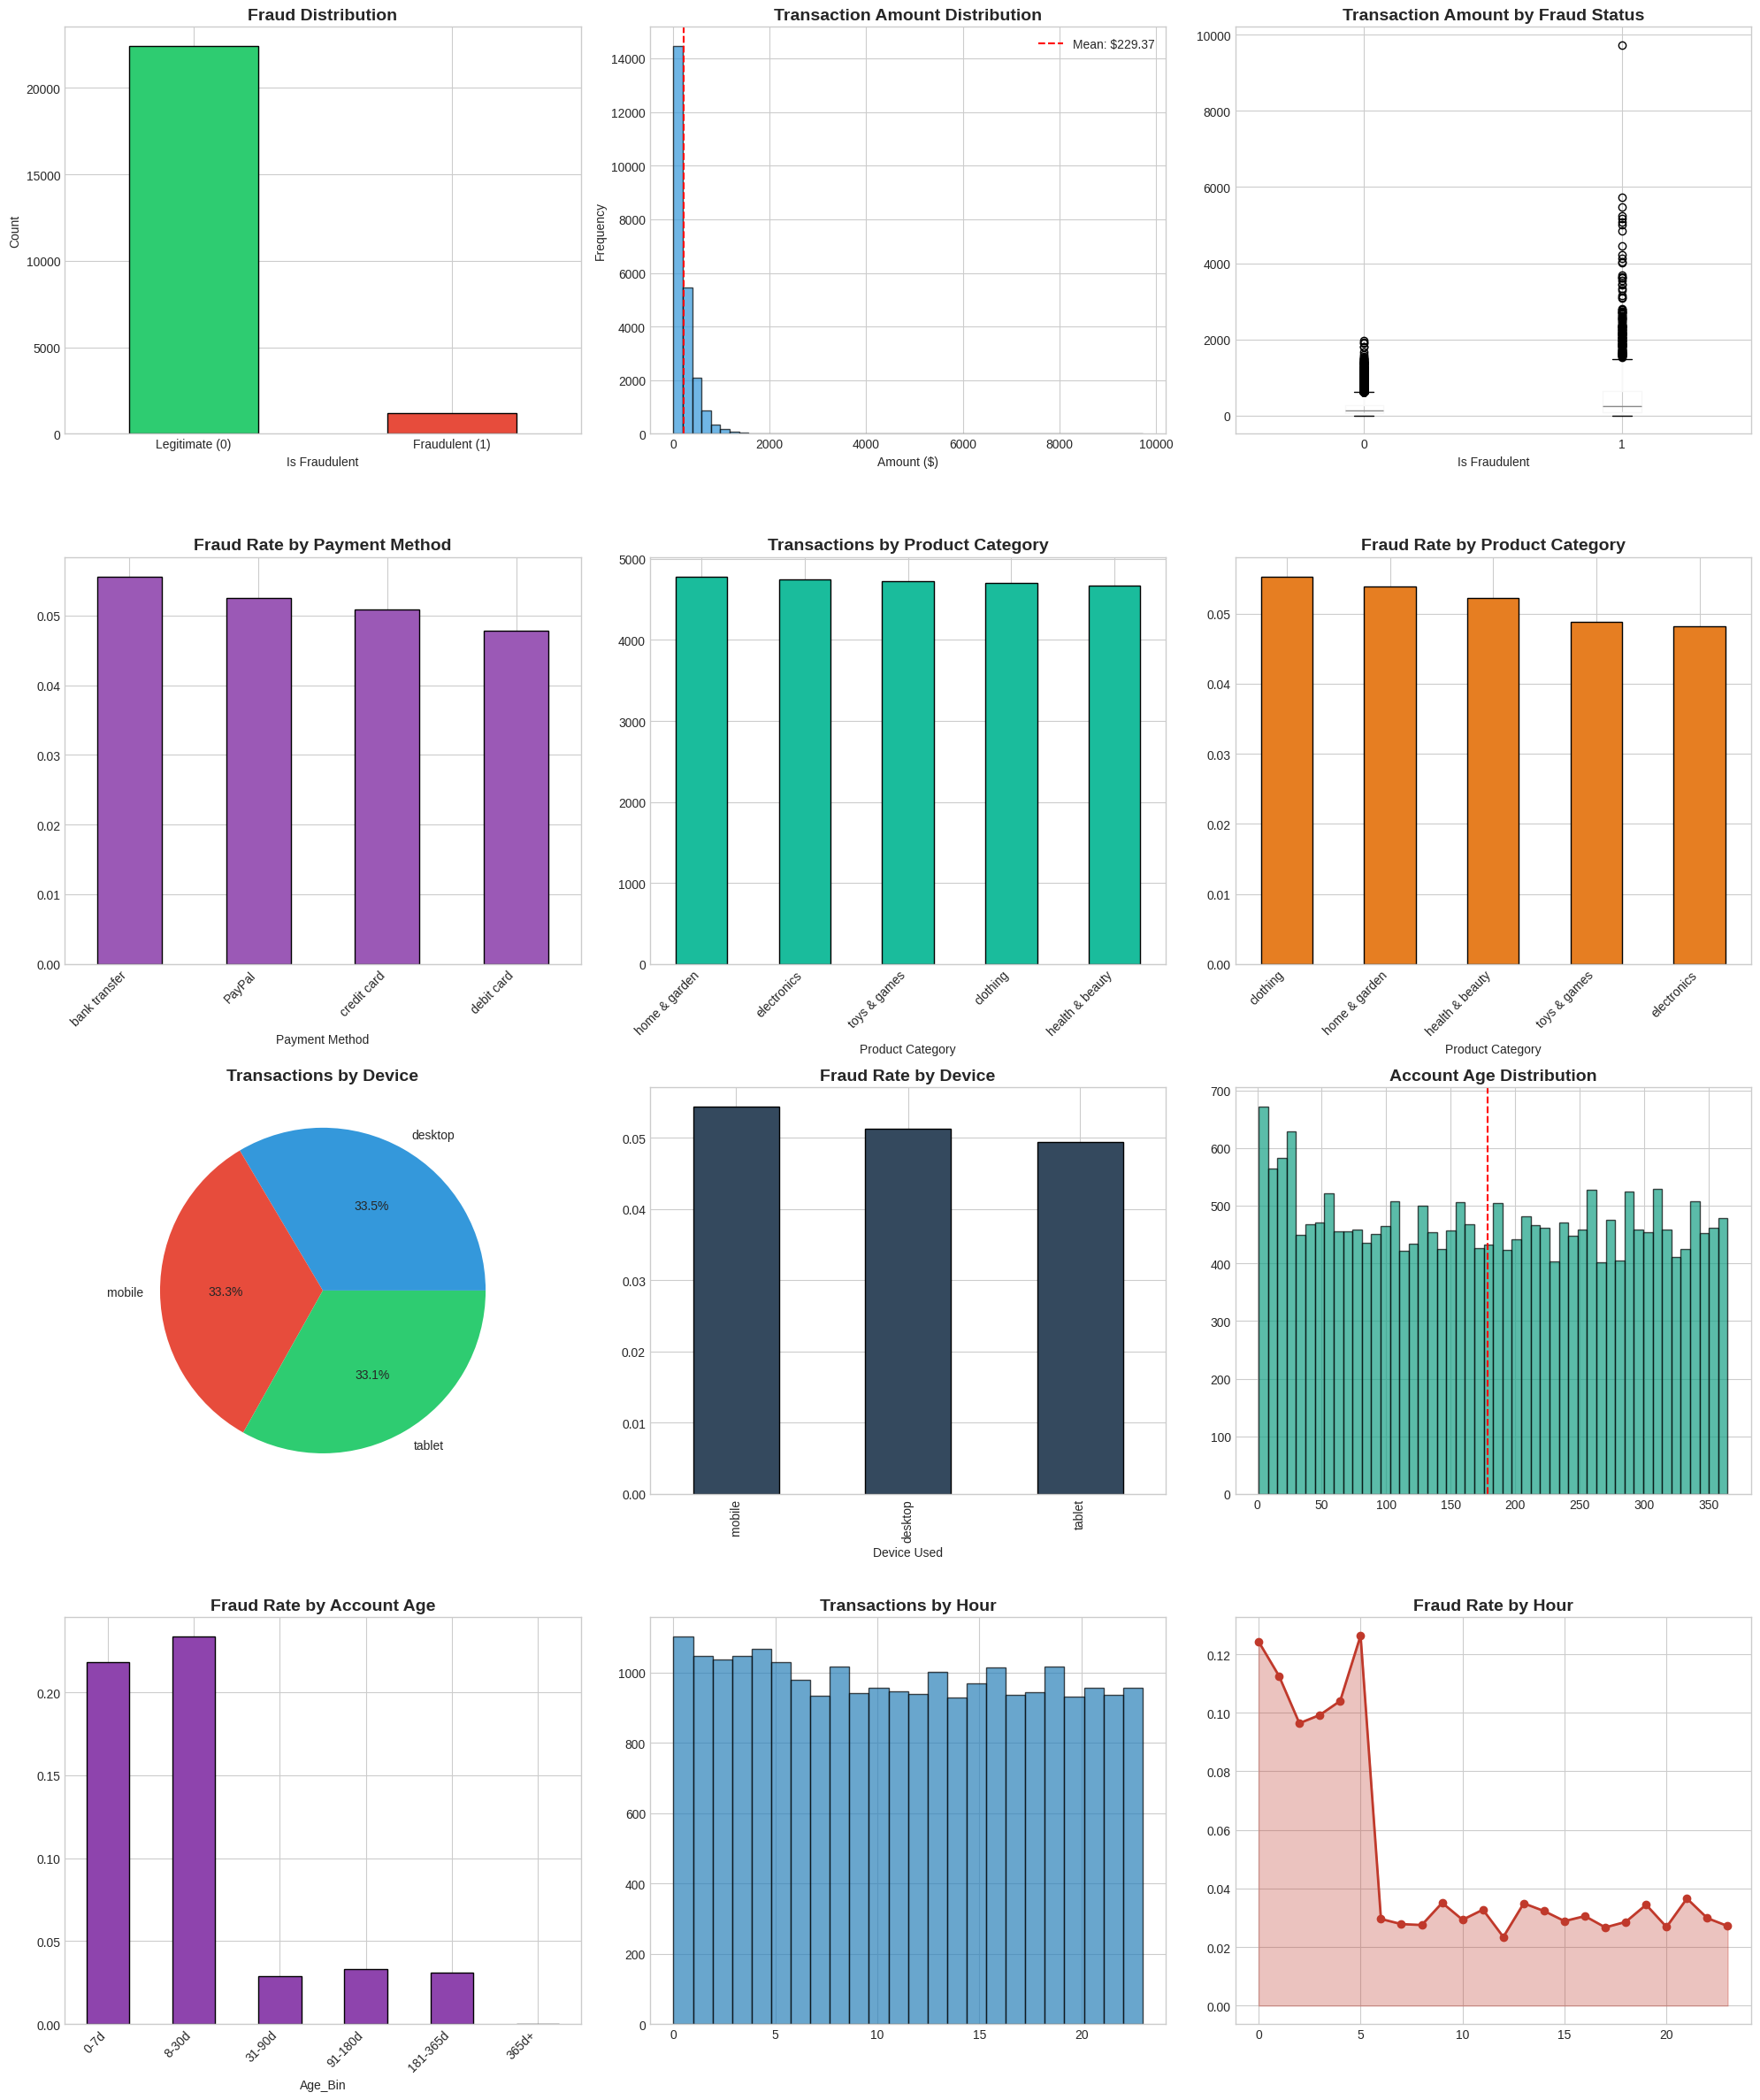

✅ Saved: eda_visualizations.png


In [11]:
fig = plt.figure(figsize=(20, 24))

# Plot 1: Fraud Distribution
ax1 = fig.add_subplot(4, 3, 1)
colors = ['#2ecc71', '#e74c3c']
df['Is Fraudulent'].value_counts().plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Fraud Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Is Fraudulent')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Legitimate (0)', 'Fraudulent (1)'], rotation=0)

# Plot 2: Transaction Amount Distribution
ax2 = fig.add_subplot(4, 3, 2)
df['Transaction Amount'].hist(bins=50, ax=ax2, color='#3498db', edgecolor='black', alpha=0.7)
ax2.set_title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Amount ($)')
ax2.set_ylabel('Frequency')
ax2.axvline(df['Transaction Amount'].mean(), color='red', linestyle='--', label=f"Mean: ${df['Transaction Amount'].mean():.2f}")
ax2.legend()

# Plot 3: Transaction Amount by Fraud Status
ax3 = fig.add_subplot(4, 3, 3)
df.boxplot(column='Transaction Amount', by='Is Fraudulent', ax=ax3)
ax3.set_title('Transaction Amount by Fraud Status', fontsize=14, fontweight='bold')
plt.suptitle('')

# Plot 4: Fraud Rate by Payment Method
ax4 = fig.add_subplot(4, 3, 4)
payment_fraud = df.groupby('Payment Method')['Is Fraudulent'].mean().sort_values(ascending=False)
payment_fraud.plot(kind='bar', ax=ax4, color='#9b59b6', edgecolor='black')
ax4.set_title('Fraud Rate by Payment Method', fontsize=14, fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

# Plot 5: Transactions by Product Category
ax5 = fig.add_subplot(4, 3, 5)
df['Product Category'].value_counts().plot(kind='bar', ax=ax5, color='#1abc9c', edgecolor='black')
ax5.set_title('Transactions by Product Category', fontsize=14, fontweight='bold')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')

# Plot 6: Fraud Rate by Product Category
ax6 = fig.add_subplot(4, 3, 6)
category_fraud = df.groupby('Product Category')['Is Fraudulent'].mean().sort_values(ascending=False)
category_fraud.plot(kind='bar', ax=ax6, color='#e67e22', edgecolor='black')
ax6.set_title('Fraud Rate by Product Category', fontsize=14, fontweight='bold')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')

# Plot 7: Transactions by Device
ax7 = fig.add_subplot(4, 3, 7)
device_counts = df['Device Used'].value_counts()
ax7.pie(device_counts, labels=device_counts.index, autopct='%1.1f%%', colors=['#3498db', '#e74c3c', '#2ecc71'])
ax7.set_title('Transactions by Device', fontsize=14, fontweight='bold')

# Plot 8: Fraud Rate by Device
ax8 = fig.add_subplot(4, 3, 8)
device_fraud = df.groupby('Device Used')['Is Fraudulent'].mean().sort_values(ascending=False)
device_fraud.plot(kind='bar', ax=ax8, color='#34495e', edgecolor='black')
ax8.set_title('Fraud Rate by Device', fontsize=14, fontweight='bold')

# Plot 9: Account Age Distribution
ax9 = fig.add_subplot(4, 3, 9)
df['Account Age Days'].hist(bins=50, ax=ax9, color='#16a085', edgecolor='black', alpha=0.7)
ax9.set_title('Account Age Distribution', fontsize=14, fontweight='bold')
ax9.axvline(df['Account Age Days'].mean(), color='red', linestyle='--')

# Plot 10: Fraud Rate by Account Age
ax10 = fig.add_subplot(4, 3, 10)
df_temp = df.copy()
df_temp['Age_Bin'] = pd.cut(df_temp['Account Age Days'], bins=[0, 7, 30, 90, 180, 365, 1000],
                            labels=['0-7d', '8-30d', '31-90d', '91-180d', '181-365d', '365d+'])
age_fraud = df_temp.groupby('Age_Bin')['Is Fraudulent'].mean()
age_fraud.plot(kind='bar', ax=ax10, color='#8e44ad', edgecolor='black')
ax10.set_title('Fraud Rate by Account Age', fontsize=14, fontweight='bold')
ax10.set_xticklabels(ax10.get_xticklabels(), rotation=45, ha='right')

# Plot 11: Transactions by Hour
ax11 = fig.add_subplot(4, 3, 11)
df['Transaction Hour'].hist(bins=24, ax=ax11, color='#2980b9', edgecolor='black', alpha=0.7)
ax11.set_title('Transactions by Hour', fontsize=14, fontweight='bold')

# Plot 12: Fraud Rate by Hour
ax12 = fig.add_subplot(4, 3, 12)
hour_fraud = df.groupby('Transaction Hour')['Is Fraudulent'].mean()
ax12.plot(hour_fraud.index, hour_fraud.values, marker='o', color='#c0392b', linewidth=2)
ax12.fill_between(hour_fraud.index, hour_fraud.values, alpha=0.3, color='#c0392b')
ax12.set_title('Fraud Rate by Hour', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: eda_visualizations.png")

### 3.7 Correlation Heatmap

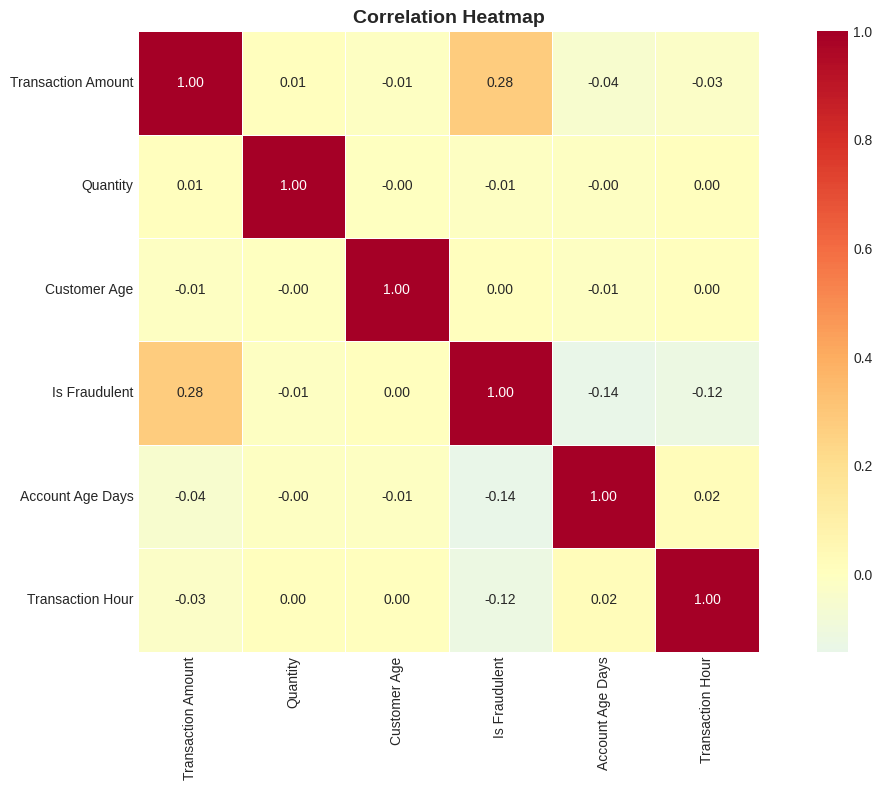

✅ Saved: eda_correlation.png


In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f', linewidths=0.5, ax=ax, square=True)
ax.set_title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_correlation.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: eda_correlation.png")

## Section 4: Feature Engineering

In [13]:
print("🔧 FEATURE ENGINEERING")
print("=" * 50)

# 4.1 Account Age Features
print("\n[1/6] Creating account age features...")
df['is_new_account'] = (df['Account Age Days'] < 7).astype(int)
df['is_very_new_account'] = (df['Account Age Days'] < 3).astype(int)
df['account_age_bin'] = pd.cut(df['Account Age Days'],
                                bins=[0, 7, 30, 90, 180, 365, 1000],
                                labels=[0, 1, 2, 3, 4, 5]).astype(int)

# 4.2 Transaction Amount Features
print("[2/6] Creating transaction amount features...")
df['amount_log'] = np.log1p(df['Transaction Amount'])
df['is_high_amount'] = (df['Transaction Amount'] > df['Transaction Amount'].quantile(0.9)).astype(int)
df['is_very_high_amount'] = (df['Transaction Amount'] > df['Transaction Amount'].quantile(0.95)).astype(int)
df['amount_bin'] = pd.qcut(df['Transaction Amount'], q=5, labels=[0, 1, 2, 3, 4]).astype(int)

# 4.3 Time Features
print("[3/6] Creating time features...")
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['day_of_week'] = df['Transaction Date'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['hour_bin'] = pd.cut(df['Transaction Hour'], bins=[-1, 6, 12, 18, 24], labels=[0, 1, 2, 3]).astype(int)
df['is_night'] = ((df['Transaction Hour'] >= 0) & (df['Transaction Hour'] < 6)).astype(int)

# 4.4 Categorical Encoding
print("[4/6] Encoding categorical features...")
le_payment = LabelEncoder()
le_category = LabelEncoder()
le_device = LabelEncoder()
df['payment_method_encoded'] = le_payment.fit_transform(df['Payment Method'])
df['product_category_encoded'] = le_category.fit_transform(df['Product Category'])
df['device_encoded'] = le_device.fit_transform(df['Device Used'])

# 4.5 Address Mismatch
print("[5/6] Creating address mismatch feature...")
df['address_mismatch'] = (df['Shipping Address'] != df['Billing Address']).astype(int)

# 4.6 Customer Age Features
print("[6/6] Creating customer age features...")
df['Customer Age'] = df['Customer Age'].clip(lower=0, upper=100)
df['is_young_customer'] = (df['Customer Age'] < 25).astype(int)
df['is_senior_customer'] = (df['Customer Age'] > 55).astype(int)
df['customer_age_bin'] = pd.cut(df['Customer Age'], bins=[-1, 25, 35, 50, 101], labels=[0, 1, 2, 3]).astype(int)

print(f"\n✅ Feature engineering complete! Total features: {df.shape[1]}")

🔧 FEATURE ENGINEERING

[1/6] Creating account age features...
[2/6] Creating transaction amount features...
[3/6] Creating time features...
[4/6] Encoding categorical features...
[5/6] Creating address mismatch feature...
[6/6] Creating customer age features...

✅ Feature engineering complete! Total features: 34


## Section 5: Prepare Data for Modeling

In [14]:
feature_cols = [
    'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour',
    'is_new_account', 'is_very_new_account', 'account_age_bin',
    'amount_log', 'is_high_amount', 'is_very_high_amount', 'amount_bin',
    'day_of_week', 'is_weekend', 'hour_bin', 'is_night',
    'payment_method_encoded', 'product_category_encoded', 'device_encoded',
    'address_mismatch', 'is_young_customer', 'is_senior_customer', 'customer_age_bin'
]

X = df[feature_cols]
y = df['Is Fraudulent']

print(f"Features used: {len(feature_cols)}")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"\nTrain set: {len(X_train):,} samples ({y_train.sum():,} fraud)")
print(f"Test set:  {len(X_test):,} samples ({y_test.sum():,} fraud)")
print(f"Class imbalance ratio: 1:{scale_pos_weight:.1f}")

Features used: 23
   1. Transaction Amount
   2. Quantity
   3. Customer Age
   4. Account Age Days
   5. Transaction Hour
   6. is_new_account
   7. is_very_new_account
   8. account_age_bin
   9. amount_log
  10. is_high_amount
  11. is_very_high_amount
  12. amount_bin
  13. day_of_week
  14. is_weekend
  15. hour_bin
  16. is_night
  17. payment_method_encoded
  18. product_category_encoded
  19. device_encoded
  20. address_mismatch
  21. is_young_customer
  22. is_senior_customer
  23. customer_age_bin

Train set: 18,907 samples (978 fraud)
Test set:  4,727 samples (244 fraud)
Class imbalance ratio: 1:18.3


## Section 6: Baseline Model Training

In [15]:
print("🚀 BASELINE MODEL TRAINING")
print("=" * 50)

baseline_results = {}

# XGBoost
print("\n[1/3] Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    scale_pos_weight=scale_pos_weight, subsample=0.8, colsample_bytree=0.8,
    random_state=42, use_label_encoder=False, eval_metric='auc', verbosity=0
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
baseline_results['XGBoost'] = {
    'model': xgb_model, 'auc': roc_auc_score(y_test, xgb_prob),
    'f1': f1_score(y_test, xgb_pred), 'recall': recall_score(y_test, xgb_pred)
}
print(f"    AUC: {baseline_results['XGBoost']['auc']:.4f} | F1: {baseline_results['XGBoost']['f1']:.4f}")

# LightGBM
print("\n[2/3] Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    scale_pos_weight=scale_pos_weight, subsample=0.8, colsample_bytree=0.8,
    random_state=42, verbose=-1
)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_prob = lgb_model.predict_proba(X_test)[:, 1]
baseline_results['LightGBM'] = {
    'model': lgb_model, 'auc': roc_auc_score(y_test, lgb_prob),
    'f1': f1_score(y_test, lgb_pred), 'recall': recall_score(y_test, lgb_pred)
}
print(f"    AUC: {baseline_results['LightGBM']['auc']:.4f} | F1: {baseline_results['LightGBM']['f1']:.4f}")

# CatBoost
print("\n[3/3] Training CatBoost...")
cb_model = cb.CatBoostClassifier(
    iterations=200, depth=6, learning_rate=0.1,
    auto_class_weights='Balanced', random_state=42, verbose=0
)
cb_model.fit(X_train, y_train)
cb_pred = cb_model.predict(X_test)
cb_prob = cb_model.predict_proba(X_test)[:, 1]
baseline_results['CatBoost'] = {
    'model': cb_model, 'auc': roc_auc_score(y_test, cb_prob),
    'f1': f1_score(y_test, cb_pred), 'recall': recall_score(y_test, cb_pred)
}
print(f"    AUC: {baseline_results['CatBoost']['auc']:.4f} | F1: {baseline_results['CatBoost']['f1']:.4f}")

🚀 BASELINE MODEL TRAINING

[1/3] Training XGBoost...
    AUC: 0.7885 | F1: 0.3293

[2/3] Training LightGBM...
    AUC: 0.7872 | F1: 0.3260

[3/3] Training CatBoost...
    AUC: 0.7995 | F1: 0.2891


In [16]:
# Baseline Comparison Table
print("\n📊 BASELINE MODEL COMPARISON")
baseline_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'AUC-ROC': [baseline_results[m]['auc'] for m in ['XGBoost', 'LightGBM', 'CatBoost']],
    'F1-Score': [baseline_results[m]['f1'] for m in ['XGBoost', 'LightGBM', 'CatBoost']],
    'Recall': [baseline_results[m]['recall'] for m in ['XGBoost', 'LightGBM', 'CatBoost']]
}).sort_values('AUC-ROC', ascending=False)
baseline_df


📊 BASELINE MODEL COMPARISON


,Model,AUC-ROC,F1-Score,Recall
2,CatBoost,0.799486,0.289062,0.606557
0,XGBoost,0.788532,0.329341,0.450820
1,LightGBM,0.787234,0.325980,0.545082


## Section 7: Hyperparameter Tuning with Optuna

In [17]:
print("⚙️ HYPERPARAMETER TUNING (Optuna)")
print("=" * 50)

N_TRIALS = 30
CV_FOLDS = 3
sampler = TPESampler(seed=42)
tuned_results = {}

⚙️ HYPERPARAMETER TUNING (Optuna)


In [18]:
# XGBoost Tuning
print(f"\n[1/3] Tuning XGBoost ({N_TRIALS} trials)...")

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42, 'use_label_encoder': False, 'eval_metric': 'auc', 'verbosity': 0
    }
    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

xgb_study = optuna.create_study(direction='maximize', sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"    Best CV AUC: {xgb_study.best_value:.4f}")
tuned_results['XGBoost'] = {'study': xgb_study, 'best_params': xgb_study.best_params}


[1/3] Tuning XGBoost (30 trials)...


  0%|          | 0/30 [00:00<?, ?it/s]

    Best CV AUC: 0.8215


In [19]:
# LightGBM Tuning
print(f"\n[2/3] Tuning LightGBM ({N_TRIALS} trials)...")

def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight, 'random_state': 42, 'verbose': -1
    }
    model = lgb.LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

lgb_study = optuna.create_study(direction='maximize', sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"    Best CV AUC: {lgb_study.best_value:.4f}")
tuned_results['LightGBM'] = {'study': lgb_study, 'best_params': lgb_study.best_params}


[2/3] Tuning LightGBM (30 trials)...


  0%|          | 0/30 [00:00<?, ?it/s]

    Best CV AUC: 0.8201


In [20]:
# CatBoost Tuning (Manual CV for compatibility)
print(f"\n[3/3] Tuning CatBoost ({N_TRIALS} trials)...")

def cb_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'auto_class_weights': 'Balanced', 'random_state': 42, 'verbose': 0
    }
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model = cb.CatBoostClassifier(**params)
        model.fit(X_cv_train, y_cv_train, verbose=0)
        prob = model.predict_proba(X_cv_val)[:, 1]
        scores.append(roc_auc_score(y_cv_val, prob))
    return np.mean(scores)

cb_study = optuna.create_study(direction='maximize', sampler=sampler)
cb_study.optimize(cb_objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"    Best CV AUC: {cb_study.best_value:.4f}")
tuned_results['CatBoost'] = {'study': cb_study, 'best_params': cb_study.best_params}


[3/3] Tuning CatBoost (30 trials)...


  0%|          | 0/30 [00:00<?, ?it/s]

    Best CV AUC: 0.8211


## Section 8: Train Final Tuned Models

In [21]:
print("🎯 TRAINING FINAL TUNED MODELS")
print("=" * 50)

# XGBoost
print("\n[1/3] Training tuned XGBoost...")
xgb_params = tuned_results['XGBoost']['best_params'].copy()
xgb_params.update({'scale_pos_weight': scale_pos_weight, 'random_state': 42,
                   'use_label_encoder': False, 'eval_metric': 'auc', 'verbosity': 0})
xgb_tuned = xgb.XGBClassifier(**xgb_params)
xgb_tuned.fit(X_train, y_train)
xgb_tuned_pred = xgb_tuned.predict(X_test)
xgb_tuned_prob = xgb_tuned.predict_proba(X_test)[:, 1]
tuned_results['XGBoost']['test_auc'] = roc_auc_score(y_test, xgb_tuned_prob)
tuned_results['XGBoost']['test_recall'] = recall_score(y_test, xgb_tuned_pred)
tuned_results['XGBoost']['model'] = xgb_tuned
print(f"    Test AUC: {tuned_results['XGBoost']['test_auc']:.4f} | Recall: {tuned_results['XGBoost']['test_recall']:.4f}")

# LightGBM
print("\n[2/3] Training tuned LightGBM...")
lgb_params = tuned_results['LightGBM']['best_params'].copy()
lgb_params.update({'scale_pos_weight': scale_pos_weight, 'random_state': 42, 'verbose': -1})
lgb_tuned = lgb.LGBMClassifier(**lgb_params)
lgb_tuned.fit(X_train, y_train)
lgb_tuned_pred = lgb_tuned.predict(X_test)
lgb_tuned_prob = lgb_tuned.predict_proba(X_test)[:, 1]
tuned_results['LightGBM']['test_auc'] = roc_auc_score(y_test, lgb_tuned_prob)
tuned_results['LightGBM']['test_recall'] = recall_score(y_test, lgb_tuned_pred)
tuned_results['LightGBM']['model'] = lgb_tuned
print(f"    Test AUC: {tuned_results['LightGBM']['test_auc']:.4f} | Recall: {tuned_results['LightGBM']['test_recall']:.4f}")

# CatBoost
print("\n[3/3] Training tuned CatBoost...")
cb_params = tuned_results['CatBoost']['best_params'].copy()
cb_params.update({'auto_class_weights': 'Balanced', 'random_state': 42, 'verbose': 0})
cb_tuned = cb.CatBoostClassifier(**cb_params)
cb_tuned.fit(X_train, y_train)
cb_tuned_pred = cb_tuned.predict(X_test)
cb_tuned_prob = cb_tuned.predict_proba(X_test)[:, 1]
tuned_results['CatBoost']['test_auc'] = roc_auc_score(y_test, cb_tuned_prob)
tuned_results['CatBoost']['test_recall'] = recall_score(y_test, cb_tuned_pred)
tuned_results['CatBoost']['model'] = cb_tuned
print(f"    Test AUC: {tuned_results['CatBoost']['test_auc']:.4f} | Recall: {tuned_results['CatBoost']['test_recall']:.4f}")

🎯 TRAINING FINAL TUNED MODELS

[1/3] Training tuned XGBoost...
    Test AUC: 0.8368 | Recall: 0.7418

[2/3] Training tuned LightGBM...
    Test AUC: 0.8313 | Recall: 0.7336

[3/3] Training tuned CatBoost...
    Test AUC: 0.8238 | Recall: 0.7254


## Section 9: Before vs After Comparison

In [22]:
print("📊 BEFORE vs AFTER TUNING COMPARISON")
print("=" * 60)

comparison_data = []
for model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    before_auc = baseline_results[model_name]['auc']
    after_auc = tuned_results[model_name]['test_auc']
    before_recall = baseline_results[model_name]['recall']
    after_recall = tuned_results[model_name]['test_recall']

    comparison_data.append({
        'Model': model_name,
        'Before AUC': f"{before_auc:.4f}",
        'After AUC': f"{after_auc:.4f}",
        'AUC Change': f"{((after_auc-before_auc)/before_auc)*100:+.2f}%",
        'Before Recall': f"{before_recall:.4f}",
        'After Recall': f"{after_recall:.4f}",
        'Recall Change': f"{((after_recall-before_recall)/before_recall)*100:+.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df

📊 BEFORE vs AFTER TUNING COMPARISON


,Model,Before AUC,After AUC,AUC Change,Before Recall,After Recall,Recall Change
0,XGBoost,0.7885,0.8368,+6.12%,0.4508,0.7418,+64.55%
1,LightGBM,0.7872,0.8313,+5.59%,0.5451,0.7336,+34.59%
2,CatBoost,0.7995,0.8238,+3.04%,0.6066,0.7254,+19.59%


In [23]:
# Best Model
best_model_name = max(tuned_results.keys(), key=lambda x: tuned_results[x]['test_auc'])
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   AUC-ROC: {tuned_results[best_model_name]['test_auc']:.4f}")
print(f"   Recall:  {tuned_results[best_model_name]['test_recall']:.4f}")


🏆 BEST MODEL: XGBoost
   AUC-ROC: 0.8368
   Recall:  0.7418


## Section 10: Feature Importance

In [24]:
best_model = tuned_results[best_model_name]['model']
importance = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("🔑 TOP 10 MOST IMPORTANT FEATURES")
importance_df.head(10)

🔑 TOP 10 MOST IMPORTANT FEATURES


,Feature,Importance
3,Account Age Days,0.382906
7,account_age_bin,0.144279
15,is_night,0.111754
4,Transaction Hour,0.075024
8,amount_log,0.074800
0,Transaction Amount,0.066345
10,is_very_high_amount,0.035455
14,hour_bin,0.028114
16,payment_method_encoded,0.023947
12,day_of_week,0.013702


## Section 11: Final Visualizations

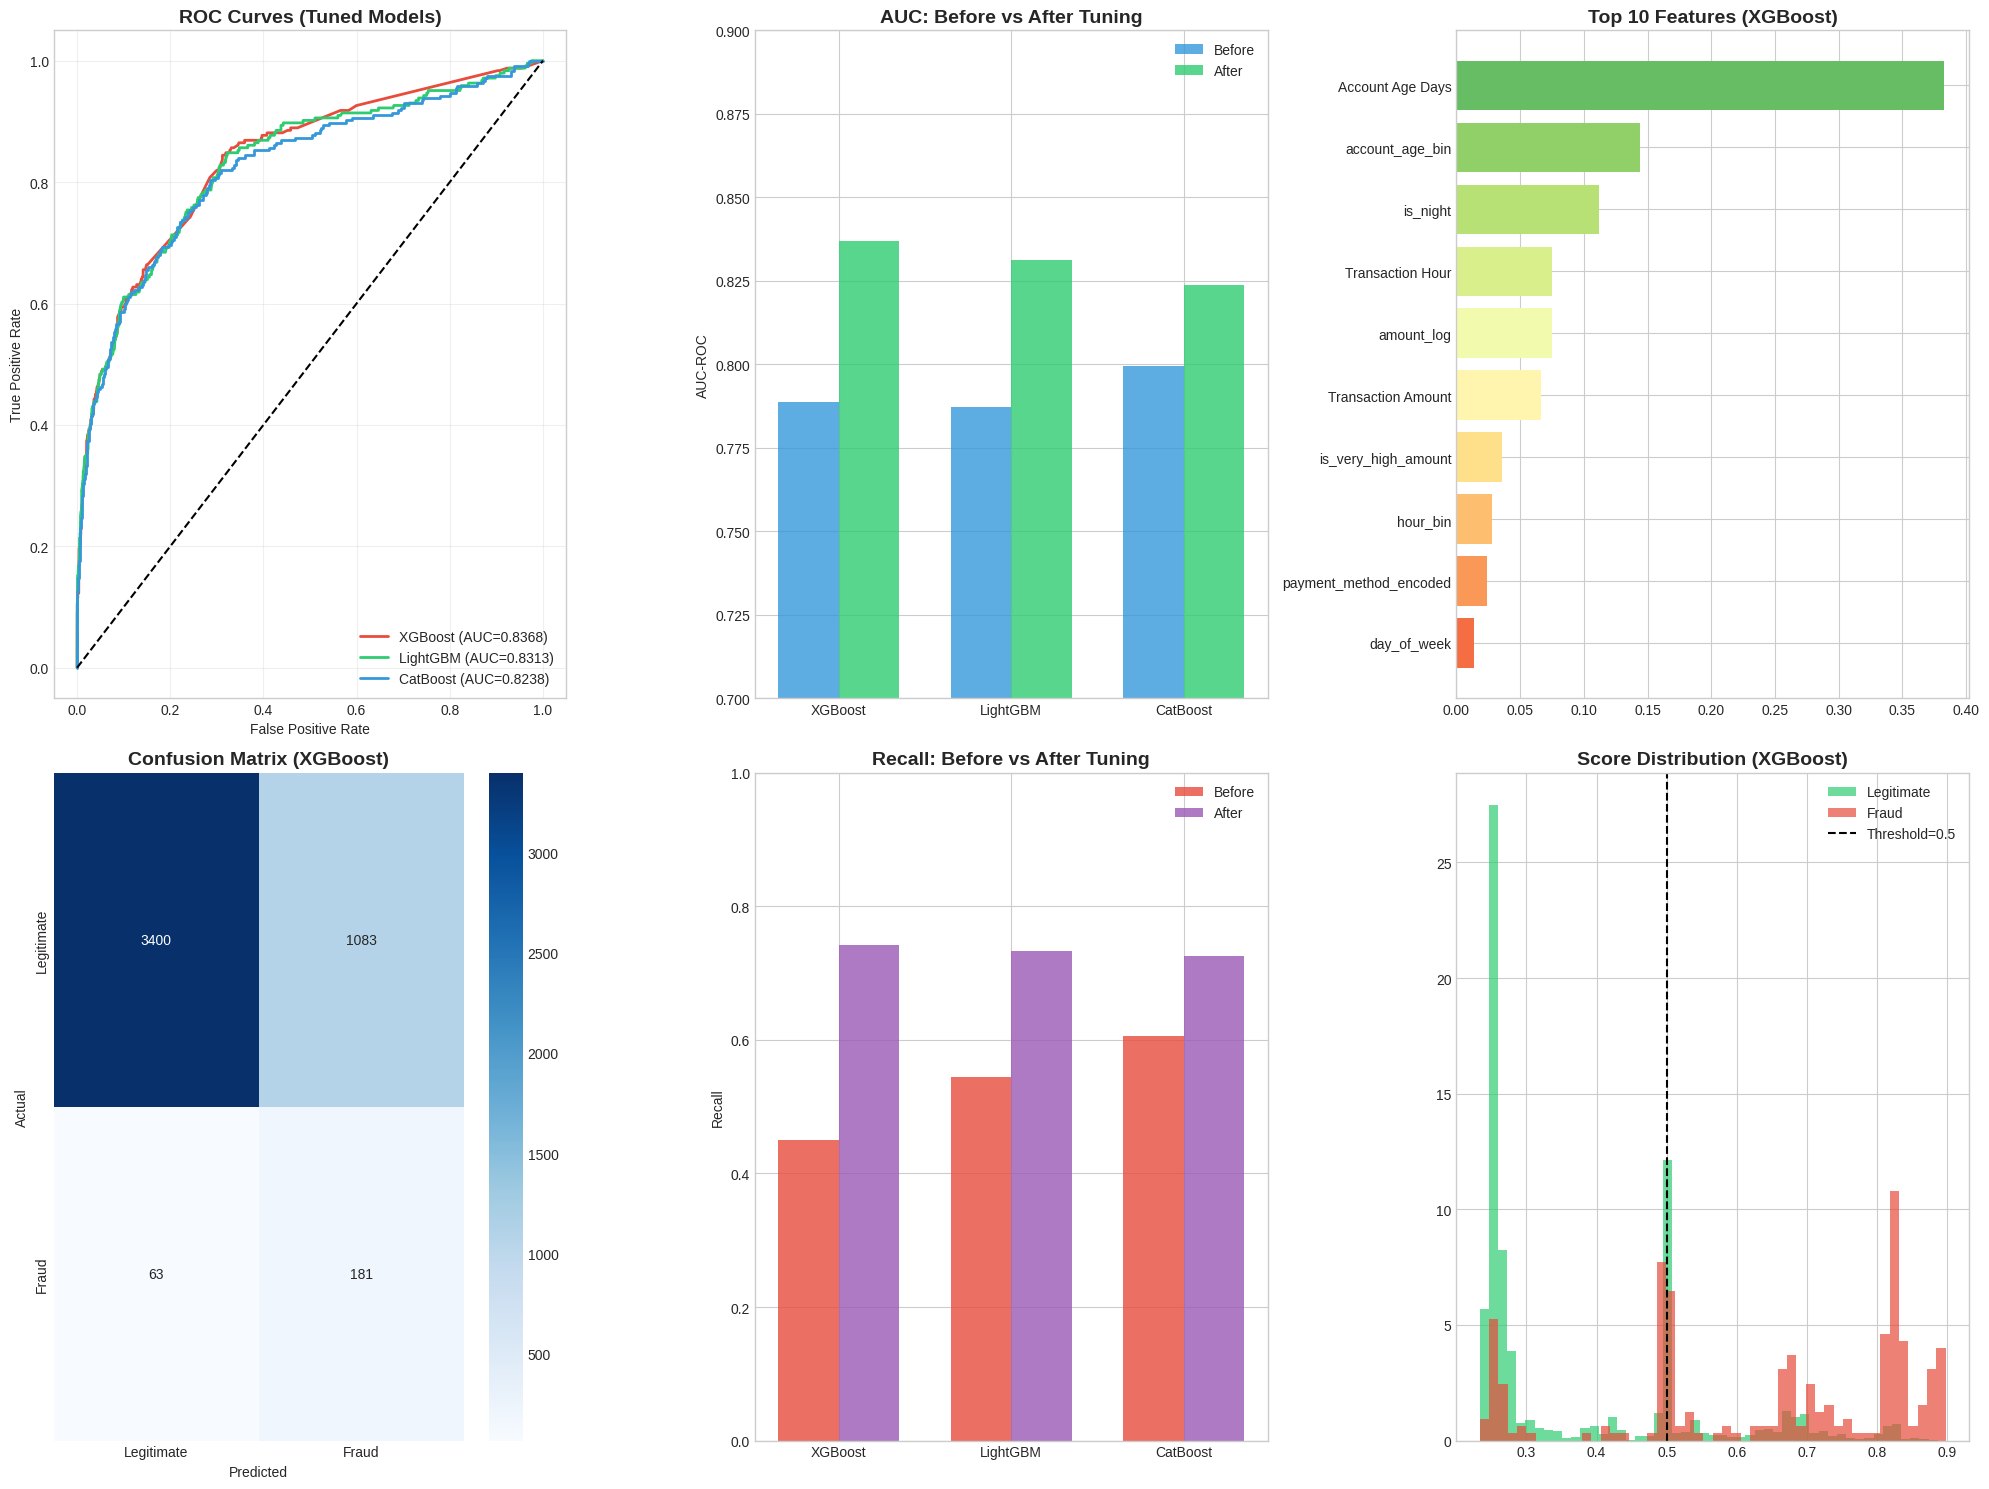

✅ Saved: final_results.png


In [25]:
fig = plt.figure(figsize=(20, 15))

# ROC Curves
ax1 = fig.add_subplot(2, 3, 1)
colors = {'XGBoost': '#e74c3c', 'LightGBM': '#2ecc71', 'CatBoost': '#3498db'}
for model_name, color in colors.items():
    prob = tuned_results[model_name]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, prob)
    ax1.plot(fpr, tpr, color=color, linewidth=2,
             label=f"{model_name} (AUC={tuned_results[model_name]['test_auc']:.4f})")
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title('ROC Curves (Tuned Models)', fontsize=14, fontweight='bold')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# AUC Comparison
ax2 = fig.add_subplot(2, 3, 2)
models = ['XGBoost', 'LightGBM', 'CatBoost']
before_auc = [baseline_results[m]['auc'] for m in models]
after_auc = [tuned_results[m]['test_auc'] for m in models]
x = np.arange(len(models))
width = 0.35
ax2.bar(x - width/2, before_auc, width, label='Before', color='#3498db', alpha=0.8)
ax2.bar(x + width/2, after_auc, width, label='After', color='#2ecc71', alpha=0.8)
ax2.set_ylabel('AUC-ROC')
ax2.set_title('AUC: Before vs After Tuning', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.set_ylim(0.7, 0.9)

# Feature Importance
ax3 = fig.add_subplot(2, 3, 3)
top_features = importance_df.head(10)
colors_feat = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 10))[::-1]
ax3.barh(top_features['Feature'], top_features['Importance'], color=colors_feat)
ax3.set_title(f'Top 10 Features ({best_model_name})', fontsize=14, fontweight='bold')
ax3.invert_yaxis()

# Confusion Matrix
ax4 = fig.add_subplot(2, 3, 4)
best_pred = tuned_results[best_model_name]['model'].predict(X_test)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
ax4.set_title(f'Confusion Matrix ({best_model_name})', fontsize=14, fontweight='bold')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

# Recall Comparison
ax5 = fig.add_subplot(2, 3, 5)
before_recall = [baseline_results[m]['recall'] for m in models]
after_recall = [tuned_results[m]['test_recall'] for m in models]
ax5.bar(x - width/2, before_recall, width, label='Before', color='#e74c3c', alpha=0.8)
ax5.bar(x + width/2, after_recall, width, label='After', color='#9b59b6', alpha=0.8)
ax5.set_ylabel('Recall')
ax5.set_title('Recall: Before vs After Tuning', fontsize=14, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(models)
ax5.legend()
ax5.set_ylim(0, 1)

# Score Distribution
ax6 = fig.add_subplot(2, 3, 6)
best_prob = tuned_results[best_model_name]['model'].predict_proba(X_test)[:, 1]
fraud_scores = best_prob[y_test == 1]
legit_scores = best_prob[y_test == 0]
ax6.hist(legit_scores, bins=50, alpha=0.7, label='Legitimate', color='#2ecc71', density=True)
ax6.hist(fraud_scores, bins=50, alpha=0.7, label='Fraud', color='#e74c3c', density=True)
ax6.axvline(x=0.5, color='black', linestyle='--', label='Threshold=0.5')
ax6.set_title(f'Score Distribution ({best_model_name})', fontsize=14, fontweight='bold')
ax6.legend()

plt.tight_layout()
plt.savefig('final_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: final_results.png")

## Section 12: Save Results

In [26]:
import pickle

# Save models
for model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    filename = f"{model_name.lower()}_tuned_model.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(tuned_results[model_name]['model'], f)
    print(f"✅ Saved: {filename}")

# Save feature columns
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print("✅ Saved: feature_columns.pkl")

# Save comparison
comparison_df.to_csv('tuning_comparison.csv', index=False)
print("✅ Saved: tuning_comparison.csv")

# Save feature importance
importance_df.to_csv('feature_importance.csv', index=False)
print("✅ Saved: feature_importance.csv")

# Save cleaned dataset
df.to_csv('Fraudulent_E-Commerce_Transaction_Data_Cleaned.csv', index=False)
print("✅ Saved: Fraudulent_E-Commerce_Transaction_Data_Cleaned.csv")

✅ Saved: xgboost_tuned_model.pkl
✅ Saved: lightgbm_tuned_model.pkl
✅ Saved: catboost_tuned_model.pkl
✅ Saved: feature_columns.pkl
✅ Saved: tuning_comparison.csv
✅ Saved: feature_importance.csv
✅ Saved: Fraudulent_E-Commerce_Transaction_Data_Cleaned.csv


## Section 13: Final Summary

In [27]:
print("="*60)
print("🎉 PIPELINE COMPLETE!")
print("="*60)

print(f"""
📊 Dataset: {len(df):,} transactions
🎯 Fraud Rate: {df['Is Fraudulent'].mean()*100:.2f}%

🏆 Best Model: {best_model_name}
   - AUC-ROC: {tuned_results[best_model_name]['test_auc']:.4f}
   - Recall:  {tuned_results[best_model_name]['test_recall']:.4f}

🔑 Top 3 Features:
   1. {importance_df.iloc[0]['Feature']}
   2. {importance_df.iloc[1]['Feature']}
   3. {importance_df.iloc[2]['Feature']}

📁 Files Saved:
   - xgboost_tuned_model.pkl
   - lightgbm_tuned_model.pkl
   - catboost_tuned_model.pkl
   - feature_columns.pkl
   - tuning_comparison.csv
   - feature_importance.csv
   - eda_visualizations.png
   - eda_correlation.png
   - final_results.png
   - Fraudulent_E-Commerce_Transaction_Data_Cleaned.csv
""")

print("="*60)
print("✅ ALL DONE!")
print("="*60)

🎉 PIPELINE COMPLETE!

📊 Dataset: 23,634 transactions
🎯 Fraud Rate: 5.17%

🏆 Best Model: XGBoost
   - AUC-ROC: 0.8368
   - Recall:  0.7418

🔑 Top 3 Features:
   1. Account Age Days
   2. account_age_bin
   3. is_night

📁 Files Saved:
   - xgboost_tuned_model.pkl
   - lightgbm_tuned_model.pkl
   - catboost_tuned_model.pkl
   - feature_columns.pkl
   - tuning_comparison.csv
   - feature_importance.csv
   - eda_visualizations.png
   - eda_correlation.png
   - final_results.png
   - Fraudulent_E-Commerce_Transaction_Data_Cleaned.csv

✅ ALL DONE!
